## Notification
需要更改的地方：
1. Import中的path（path中需要建立link_id文件夹）
2. Read Data中的t和events
3. Risk Feature（Raw）中的start_date和duration

## Import

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from util import *
from DataStructures import *
import math
from shapely import wkt
import time
from tqdm import tqdm
from math import sin, cos, asin
from sklearn.preprocessing import MinMaxScaler
import warnings
from scipy.spatial import distance
from model import model, Transformer
from evaluator import stepwise_error, compute_error
import matplotlib.colors as colors
import random, os
import json, requests
from urllib.parse import urlencode
import tensorflow as tf
import matplotlib
from spektral.layers import GCNConv, GlobalAvgPool


pd.options.mode.chained_assignment = None
tqdm.pandas(desc='apply')
pd.set_option('display.float_format', lambda x: '%.1f' % x)
path = '../data/final_data/'
interval = 30
start_date = '2023-12-26'
start_date = datetime.strptime(start_date, '%Y-%m-%d')
duration = 60
warnings.filterwarnings('ignore')
scale = 1
length, n_steps = 4, 2
train_ratio = 0.8
class_dict = {
    '主干路': 0,
    '高速路': 1,
    '次干路': 2,
    '支路': 3,
    '快速路': 4,
    '小路': 5
}
grid_lons = [113.605, 113.615, 113.625]
grid_lats = [22.85, 22.86, 22.87, 22.88, 22.89]
type_car = ['车道偏离', '保持车距', '行人碰撞', '急加速', '急减速', '右侧后方接近报警', '急转弯', '超限速告警', '盲区行人报警']

## Read Data

70


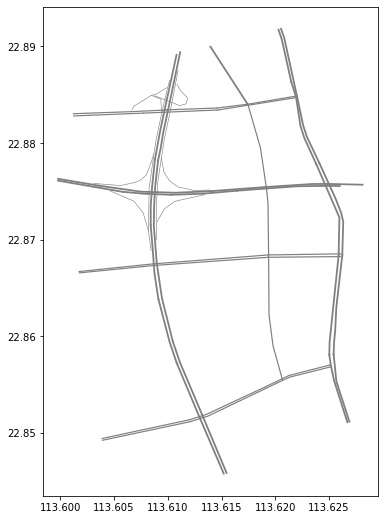

70 70 17585 38926
70 91


In [2]:
t = pd.read_table(f'{path}road_network.txt', sep='@')

# 建立links & nodes
Coord_tool = Coords()
nodes_coords = {}
links = {}
node_id = 0
main_links = {}

def isInBound_new(lon, lat):
    # 范围经纬坐标，虎门区域
    # x1 = 113.590
    # x2 = 113.694
    # y1 = 22.829
    # y2 = 22.892
    # x1 = 113.575
    # x2 = 113.633
    # y1 = 22.829
    # y2 = 22.895
    x1 = 113.597
    x2 = 113.628
    y1 = 22.85
    y2 = 22.89
    if lon > x1 and lon < x2 and lat > y1 and lat < y2:
        return True
    else:
        return False
    
for info in zip(t['linkid'], t['linkname'], t['lanes'], t['linkshape'], t['linkclass']):
    link_id = info[0]
    link_name = info[1]
    lanes = int(info[2])
    link_pos = info[3]
    link_class = int(info[4])
    
    lons, lats = wkt.loads(link_pos).xy
    
    # 起点的node
    if (lons[0], lats[0]) not in nodes_coords.keys():
        nodes_coords[(lons[0], lats[0])] = Node(node_id, lon=lons[0], lat=lats[0])
        node_id += 1
    else:
        nodes_coords[(lons[0], lats[0])].num_link += 1

    # 终点的node
    if (lons[-1], lats[-1]) not in nodes_coords.keys():
        nodes_coords[(lons[-1], lats[-1])] = Node(node_id, lon=lons[-1], lat=lats[-1])
        node_id += 1
    else:
        nodes_coords[(lons[-1], lats[-1])].num_link += 1
    
    # link
    new_link = Link(link_id, nodes_coords[(lons[0], lats[0])].id, nodes_coords[(lons[-1], lats[-1])].id, numLanes=lanes, shape=link_pos, name=link_name, road_class=link_class)
    links[link_id] = new_link
    main_links[link_id] = new_link
        

nodes = {}
for coords, node in nodes_coords.items():
    nodes[node.id] = node

print(len(links))


fig = plt.figure(figsize=(6, 9))
used_links = {}
count = 0
for link in main_links.values():
    #if isInBound_new(nodes[link.fnode].lon, nodes[link.fnode].lat) and isInBound_new(nodes[link.tnode].lon, nodes[link.tnode].lat):
    count += 1
    used_links[link.id] = link

for link in used_links.values():
    xs = [nodes[link.fnode].lon, nodes[link.tnode].lon]
    ys = [nodes[link.fnode].lat, nodes[link.tnode].lat]
    xs, ys = wkt.loads(link.shape).xy
    plt.plot(xs, ys, color='grey', linewidth=(4-link.road_class)*0.6)

       
events = pd.read_csv('../data/2023-11-23to2023-12-03/data_alarm/total.csv', header=0, index_col=0)
count_event = 0
lons, lats = [], []
for i in range(len(events)):
    lon, lat = events['经度'].iloc[i], events['纬度'].iloc[i]
    if isInBound_new(lon, lat):
        lons.append(lon)
        lats.append(lat)
        count_event += 1

#plt.scatter(lons, lats, color='red', s=1)
plt.show()
print(len(main_links), count, count_event, len(events))
print(len(used_links), len(nodes))

In [6]:
t = pd.read_table('../data/gaode/tb_all_road_2023_dongguan.txt', sep='@')

# 建立links & nodes
Coord_tool = Coords()
nodes_coords = {}
links = {}
node_id = 0
old_links = {}

def isInBound_new(lon, lat):
    # 范围经纬坐标，虎门区域
    # x1 = 113.590
    # x2 = 113.694
    # y1 = 22.829
    # y2 = 22.892
    # x1 = 113.575
    # x2 = 113.633
    # y1 = 22.829
    # y2 = 22.895
    x1 = 113.597
    x2 = 113.628
    y1 = 22.85
    y2 = 22.89
    if lon > x1 and lon < x2 and lat > y1 and lat < y2:
        return True
    else:
        return False
    
for info in zip(t['nds_id'], t['link_name'], t['link_class'], t['lanes'], t['link_dir'], t['link_position']):
    link_id = info[0]
    link_name = info[1]
    road_class = info[2]
    lanes = int(info[3])
    link_dir = int(info[4])
    link_pos = info[5]
    
    lons, lats = wkt.loads(link_pos).xy
    
    # 起点的node
    if (lons[0], lats[0]) not in nodes_coords.keys():
        nodes_coords[(lons[0], lats[0])] = Node(node_id, lon=lons[0], lat=lats[0])
        node_id += 1
    else:
        nodes_coords[(lons[0], lats[0])].num_link += 1

    # 终点的node
    if (lons[-1], lats[-1]) not in nodes_coords.keys():
        nodes_coords[(lons[-1], lats[-1])] = Node(node_id, lon=lons[-1], lat=lats[-1])
        node_id += 1
    else:
        nodes_coords[(lons[-1], lats[-1])].num_link += 1
    
    # link
    new_link = Link(link_id, nodes_coords[(lons[0], lats[0])].id, nodes_coords[(lons[-1], lats[-1])].id, link_dir, numLanes=lanes, shape=link_pos, name=link_name, road_class=road_class)
    links[link_id] = new_link

old_nodes = {}
for coords, node in nodes_coords.items():
    old_nodes[node.id] = node

for link in links.values():
    if isInBound_new(old_nodes[link.fnode].lon, old_nodes[link.fnode].lat) and isInBound_new(old_nodes[link.tnode].lon, old_nodes[link.tnode].lat) and link.road_class in ['主干路', '高速路', '快速路']:
        old_links[link.id] = link

In [ ]:
len(old_links)

409

## Function Defination

In [3]:
def point_dist(lon1, lat1, lon2, lat2):
    rad1 = lat1 * pi / 180
    rad2 = lat2 * pi / 180
    diff = rad1 - rad2
    b = (lon1 - lon2) * pi / 180
    s = 2 * asin(math.sqrt(pow(sin(diff/2), 2) + cos(rad1) * cos(rad2) * pow(sin(b/2), 2))) * a
    return s


def line_dist(lon1, lat1, lon2, lat2, lon, lat):
    d1 = point_dist(lon1, lat1, lon2, lat2)
    d2 = point_dist(lon2, lat2, lon, lat)
    d3 = point_dist(lon1, lat1, lon, lat)
    if d2 * d2 >= d3 * d3 + d1 * d1:
        return d3
    if d3 * d3 >= d2 * d2 + d1 * d1:
        return d2
    l = (d1 + d2 + d3) / 2
    s = math.sqrt(l * (l - d1) * (l - d2) * (l - d3))
    return 2 * s / d1


def get_dist(lon, lat, link_):
    xs_gcj, ys_gcj = wkt.loads(link_.shape).xy
    min_dist = math.inf
    for i in range(len(xs_gcj) - 1):
        lon1, lat1 = xs_gcj[i], ys_gcj[i]
        lon2, lat2 = xs_gcj[i + 1], ys_gcj[i + 1]
        dist = line_dist(lon1, lat1, lon2, lat2, lon, lat)
        if dist < min_dist:
            min_dist = dist
    return min_dist


def judge_link(lon, lat, links_, show=False):
    if lat < 22.83:
        return None
    id_list = []
    dist_list = []
    for link in links_.values():
        dist_list.append(get_dist(lon, lat, link))
        id_list.append(link.id)
    if show:
        print(min(dist_list))
        link_id = id_list[np.argmin(dist_list)]
        shape = links_[link_id].shape
        print(shape)
        xs_gcj, ys_gcj = wkt.loads(shape).xy
        fig = plt.figure(figsize=(12, 16))
        for link in links_.values():
            xs_gcj_, ys_gcj_ = wkt.loads(link.shape).xy
            plt.plot(xs_gcj_, ys_gcj_, color='grey', linewidth=1, zorder=1)
        plt.plot(xs_gcj, ys_gcj, color='blue', linewidth=2, zorder=2)
        plt.scatter(lon, lat, color='red', s=20, zorder=3)
        plt.show()
    if min(dist_list) > 20:
        return None
    res = id_list[np.argmin(dist_list)]
    return res


def link_length(link):
    xs, ys = wkt.loads(link.shape).xy
    xs_gcj = []
    ys_gcj = []
    for i in range(len(xs)):
        gcjLon, gcjLat = wgs84_to_gcj02(xs[i], ys[i])
        xs_gcj.append(gcjLon)
        ys_gcj.append(gcjLat)
    dist = 0
    for i in range(len(xs_gcj) - 1):
        dist += point_dist(xs_gcj[i], ys_gcj[i], xs_gcj[i + 1], ys_gcj[i + 1])
    return dist


def judge_connect(link1, link2):
    xs1, ys1 = wkt.loads(link1.shape).xy
    xs2, ys2 = wkt.loads(link2.shape).xy
    for i in range(len(xs1)):
        for j in range(len(xs2)):
            if point_dist(xs1[i], ys1[i], xs2[j], ys2[j]) < 30:
                return True
    return False


def judge_time_index(hour, minute):
    total = hour * 60 + minute
    return math.floor(total / interval)


def search(date, link_id, time_index, df, name):
    ans_col = df.loc[(df['link_id'] == str(link_id)) & (df['date'] == date) & (df['time_index'] == time_index), :]
    if len(ans_col) == 0:
        return 0
    elif len(ans_col) == 1:
        return ans_col[name].iloc[0]


def search_count(day, link_id, time_index, df, id_list):
    number = int(24 * 60 / interval)
    n = len(id_list)
    index = day * number * n + time_index * n + id_list.index(link_id)
    return df['count'].iloc[index]


def date_InBound(date):
    end_date = start_date + timedelta(days=duration)
    end_date = str(end_date)[:10]
    if str(start_date)[:10] <= date <= end_date:
        return True
    else:
        return False


def judge_holiday(date):
    holiday_list = ['2023-12-30', '2023-12-31', '2024-01-01', '2024-02-09', '2024-02-10', '2024-02-11', '2024-02-12', '2024-02-13', '2024-02-14', '2024-02-15', '2024-02-16', '2024-02-17', '2024-02-05', '2024-02-06', '2024-02-07', '2024-02-08', '2024-02-18', '2024-02-19']
    weekend_list = ['2024-01-06', '2024-01-07', '2024-01-13', '2024-01-14', '2024-01-20', '2024-01-21', '2024-01-27', '2024-01-28', '2024-02-03']
    if date in holiday_list:  # or date in weekend_list
        return 1
    else:
        return 0


def inverse_time(index):
    total_min = index * interval
    total_hour = total_min / 60
    total_hour = '%02d' % total_hour
    total_min %= 60
    total_min = '%02d' % total_min
    return total_hour + ':' + total_min

count     70.0
mean     723.9
std      241.3
min      240.8
25%      584.7
50%      696.7
75%      862.1
max     1444.7
dtype: float64


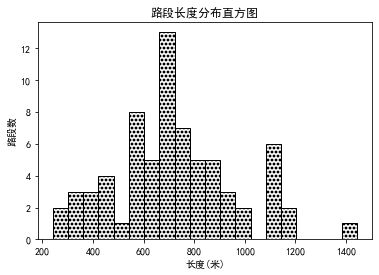

In [109]:
length_list = [link_length(link) for link in used_links.values()]
matplotlib.rc('font', family='SimHei', weight='bold')
print(pd.Series(length_list).describe())
plt.hist(length_list, 20, color='w', edgecolor='k', hatch=r'ooo')
plt.title('路段长度分布直方图')
plt.xlabel('长度(米)')
plt.ylabel('路段数')
plt.show()

## Event Processing

### Event Classification

In [102]:
events = pd.read_csv('../data/sf_0418/SF_complete_data_0418.csv', header=0)
len(events)

449416

In [ ]:
n = 10
events = pd.read_csv('../data/sf_0418/SF_complete_data_0418.csv', header=0)
events['InBound'] = events.apply(lambda x: isInBound_new(x[2], x[3]), axis=1)
events_eff = events[events['InBound'] == True]
events_eff['时间'] = events_eff['时间'].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(int(x / 1000))))
events_eff['date'] = events_eff['时间'].apply(lambda x: x[:10])
events_eff['dateInBound'] = events_eff['date'].apply(lambda x: date_InBound(x))
events_eff = events_eff[events_eff['dateInBound'] == True]

size = int(len(events_eff) / n)
for i in range(n):
    if i != n - 1:
        events_sub = events_eff.iloc[i*size:(i+1)*size+1, :]
    else:
        events_sub = events_eff.iloc[i*size:, :]
    #print(events_sub.head(10))
    events_sub['link_id'] = events_sub.progress_apply(lambda x: 'a' + str(judge_link(x[2], x[3], used_links)), axis=1)
    events_sub.to_csv(f'{path}link_id/total_linkid_{i + 1}_new.csv')

apply: 100%|██████████| 13965/13965 [00:48<00:00, 289.21it/s]


### Merging Results

In [7]:
events = None
n = 10
for i in range(n):
    df = pd.read_csv(f'{path}link_id/total_linkid_{i + 1}_new.csv', header=0, index_col=0)
    events = pd.concat([events, df])
events['valid'] = events['报警名称'].apply(lambda x:x in type_car)
events = events[events['valid'] == True]
events.to_csv(f'{path}link_id/total_linkid_all_new.csv')
events['link_id'] = events['link_id'].apply(lambda x:x[1:])
events_eff = events[events['link_id'] != 'None']
print(len(events), len(events_eff))

102444 83116


In [8]:
cnt = 0
for i in range(len(events)):
    lon, lat = events['经度'].iloc[i], events['纬度'].iloc[i]
    if isInBound_new(lon, lat):
        cnt += 1
cnt

102444

### Classification Visualization

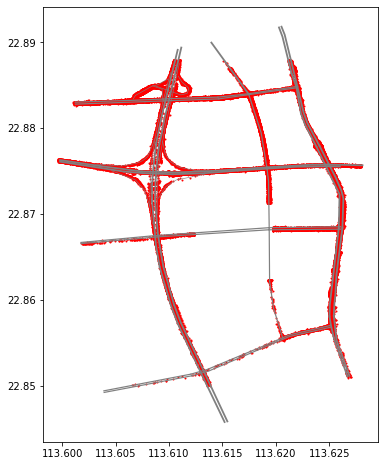

83116 83116


In [5]:
fig = plt.figure(figsize=(6, 8))
for link in used_links.values():
    xs = [nodes[link.fnode].lon, nodes[link.tnode].lon]
    ys = [nodes[link.fnode].lat, nodes[link.tnode].lat]
    xs, ys = wkt.loads(link.shape).xy
    plt.plot(xs, ys, color='grey', linewidth=(4-link.road_class)*0.6)
        
events = pd.read_csv(f'{path}link_id/total_linkid_all_new.csv', header=0, index_col=0)
events['link_id'] = events['link_id'].apply(lambda x:x[1:])
events_eff = events[events['link_id'] != 'None']
lons, lats = [], []
for i in range(len(events_eff)):
    lon, lat = events_eff['经度'].iloc[i], events_eff['纬度'].iloc[i]
    if isInBound_new(lon, lat):
        lons.append(lon)
        lats.append(lat)

plt.scatter(lons, lats, color='red', s=1)
plt.show()
print(len(lons), len(lats))

## Feature Extraction

### Adjacency Feature

#### Adjacency Feature Extraction

In [ ]:
id_list = list(used_links.keys())
n = len(id_list)
df = pd.DataFrame(data=None, columns=id_list)
cnt = 0
start = time.time()
for i in range(n):
    for j in range(n):
        link1, link2 = used_links[id_list[i]], used_links[id_list[j]]
        df.loc[i, id_list[j]] = 1 if judge_connect(link1, link2) else 0
    cnt += 1
    if cnt % 10 == 0:
        now = time.time()
        eta = (now - start) * (n - cnt) / cnt
        print('Finished:{}/{}\t{}%\tTime:{}s\tETA:{}s'.format(cnt, n, '%.2f' % (cnt / n * 100), '%.1f' % (now - start), '%.1f' % eta))
df.index = ['a' + str(link_id) for link_id in id_list]
df.columns = ['a' + str(link_id) for link_id in id_list]
df.to_csv(f'{path}adjacency.csv')

Finished:10/70	14.29%	Time:0.2s	ETA:1.1s
Finished:20/70	28.57%	Time:0.4s	ETA:0.9s
Finished:30/70	42.86%	Time:0.5s	ETA:0.7s
Finished:40/70	57.14%	Time:0.7s	ETA:0.5s
Finished:50/70	71.43%	Time:0.9s	ETA:0.4s
Finished:60/70	85.71%	Time:1.0s	ETA:0.2s
Finished:70/70	100.00%	Time:1.3s	ETA:0.0s


#### Adjacency Visualization

55 ['4', '5', '11', '12', '42', '43', '45', '46', '54', '56']


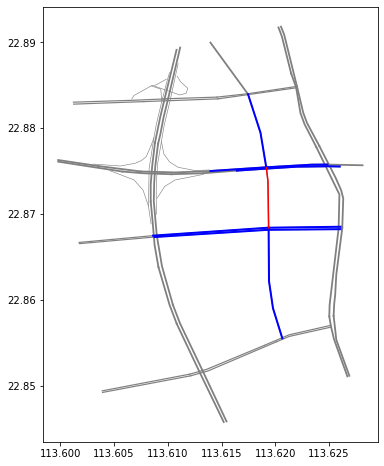

In [ ]:
id_list = list(used_links.keys())
n = len(id_list)
df = pd.read_csv(f'{path}adjacency.csv', header=0, index_col=0)
df.columns = [col[1:] for col in df.columns]
df.index = [ind[1:] for ind in df.index]
target = id_list.index(55)
link0 = used_links[id_list[target]]
ids = []
for i in range(n):
    if df[str(id_list[target])].iloc[i] == 1 and i != target:
        ids.append(df.index[i])
print(id_list[target], ids)
fig = plt.figure(figsize=(6, 8))
for link in used_links.values():
    xs, ys = wkt.loads(link.shape).xy
    plt.plot(xs, ys, color='grey', linewidth=(4-link.road_class)*0.6, zorder=1)
xs, ys = wkt.loads(link0.shape).xy
plt.plot(xs, ys, color='red', zorder=3)
for link_id in ids:
    link = used_links[int(link_id)]
    xs, ys = wkt.loads(link.shape).xy
    plt.plot(xs, ys, color='blue', zorder=2, linewidth=2)
plt.show()

In [ ]:
link_corr_list = []
link_corr_list.append(['5132599044324983232'])
link_corr_list.append(['5132599057209884978'])
link_corr_list.append(['5132599057209884980'])
link_corr_list.append(['5132599057209885243', '5132599057209885244'])
link_corr_list.append(['5132599057209885243'])
link_corr_list.append(['5132599057209885243'])
link_corr_list.append(['5132599044324983231', '5132599057209885060'])
link_corr_list.append(['5132599057209884993'])
link_corr_list.append(['5132599057209885012'])
link_corr_list.append(['5132599057209885243']) # 10
link_corr_list.append(['5132599057209885243'])
link_corr_list.append(['5132599057209885243'])
link_corr_list.append(['5132599048619950808', '5132599048619951054'])
link_corr_list.append(['5132599048619950808'])
link_corr_list.append(['5132599057209884990'])
link_corr_list.append(['5132599082979689187', '5132599082979688941'])
link_corr_list.append(['5132599082979689187'])
link_corr_list.append(['5132599082979689187'])
link_corr_list.append(['5132599082979689187'])
link_corr_list.append(['5132599057209885001']) # 20
link_corr_list.append(['5132599057209885001'])
link_corr_list.append(['5132599082979688843'])
link_corr_list.append(['5132599082979688944', '5132599091569623566', '5132599091569623569', '5132599091569623473', '5132599082979688962'])
link_corr_list.append(['5132599082979689187'])
link_corr_list.append(['5132599082979689187'])
link_corr_list.append(['5132599057209884939', '5132599057209884979'])
link_corr_list.append(['5132599057209885183', '5132599057209884939'])
link_corr_list.append(['5132599057209885182', '5132599057209885226', '5132599048619950803']) # 5132599048619950804 2
link_corr_list.append(['5132599057209884885', '5132599057209884884', '5132599057209884736', '5132599057209885146', '5132599057209885196' ,'5132599057209885197'])
link_corr_list.append(['5132599057209885259', '5132599057209885258', '5132599057209884714', '5132599057209884715', '5132599052914917687']) # 30
link_corr_list.append(['5132599057209884945', '5132599057209884946'])
link_corr_list.append(['5132599057209884998']) # 32
link_corr_list.append(['5132599048619950797', '5132599048619950799']) # 33
link_corr_list.append(['5132599057209884897', '5132599048619950934', '5132599048619950774', '5132599057209884896', '5132599057209885056', '5132599057209885016'])
link_corr_list.append(['5132599057209885226', '5132599048619950963'])
link_corr_list.append(['5132599048619950955', '5132599048619950965', '5132599048619950971', '5132599048619950825', '5132599057209885175', '5132599057209885109', '5132599057209885184', '5132599048619950912', '5132599048619950963', '5132599048619950991']) # 36
link_corr_list.append(['5132599082979688942', '5132599057209885064', '5132599057209884930'])
link_corr_list.append(['5132599057209884952', '5132599082979688765'])
link_corr_list.append(['5132599082979688763', '5132599082979688770', '5132599082979689038'])
link_corr_list.append(['5132599057209884943', '5132599082979688768', '5132599082979688763']) # 40
link_corr_list.append(['5132599082979689052', '5132599082979688613', '5132599082979688610'])
link_corr_list.append(['5132599082979688604', '5132599082979688863', '5132599082979688513', '5132599082979689004', '5132599082979689000', '5132599082979688841'])
link_corr_list.append(['5132599082979688662', '5132599087274656255', '5132599087274656254'])
link_corr_list.append(['5132599082979688607', '5132599082979688606', '5132599082979688830', '5132599082979688829', '5132599082979688674'])
link_corr_list.append(['5132599082979688994', '5132599082979689036', '5132599082979688865', '5132599082979688864', '5132599082979688723', '5132599082979689014'])
link_corr_list.append(['5132599082979688824', '5132599082979689053', '5132599087274656496'])
link_corr_list.append(['5132604958494949485', '5132604958494949760', '5132604958494949546', '5132604958494949860', '5132604958494949862'])
link_corr_list.append(['5132604958494949644', '5132599091569623156', '5132599091569623652', '5132599091569623321', '5132599091569623708', '5132599091569623160', '5132599095864590990'])
link_corr_list.append(['5132599095864590588', '5132599095864590699', '5132599095864590700', '5132599095864590938'])
link_corr_list.append(['5132604958494949835', '5132604958494949556', '5132604958494949557', '5132604958494949636']) # 50
link_corr_list.append(['5132604958494950044', '5132604958494950043', '5132599091569623459', '5132599091569623487', '5132599091569623621', '5132599091569623093', '5132599091569623140'])
link_corr_list.append(['5132599095864590695', '5132599095864590696', '5132599095864590571', '5132599095864590570'])
link_corr_list.append(['5132599048619950181', '5132599057209884713', '5132599048619950573'])
link_corr_list.append(['5132599057209885041', '5132599057209885034', '5132599057209885018', '5132599057209884922'])
link_corr_list.append(['5132599082979689049', '5132599082979689186', '5132599082979689061'])
link_corr_list.append(['5132599082979689092', '5132599082979689183', '5132599082979689091', '5132599085127172831'])
link_corr_list.append(['5132599044324983009', '5132599057209884883', '5132599057209884734', '5132599057209885278'])
link_corr_list.append(['5132599057209885260', '5132599057209884718', '5132599057209884784'])
link_corr_list.append(['5132599052914918010', '5132599052914918146', '5132599052914918151', '5132599052914917377'])
link_corr_list.append(['5132599052914918009', '5132599052914917901', '5132599061504852741', '5132599061504852257', '5132599061504852439', '5132599061504852820']) # 60
link_corr_list.append(['5132599061504852336', '5132599061504852743', '5132599087274655977', '5132599087274656370'])
link_corr_list.append(['5132599087274655890', '5132599087274655892', '5132599095864590629', '5132599095864590625'])
link_corr_list.append(['5132599095864590502', '5132599095864590717', '5132599095864590713', '5132599095864590714'])
link_corr_list.append(['5132599052914917877', '5132599052914917741', '5132599052914917847', '5132599052914917952'])
link_corr_list.append(['5132599061504852831', '5132599061504853014', '5132599061504853015'])
link_corr_list.append(['5132599061504852735', '5132599061504852745', '5132599087274656313', '5132599087274656243', '5132599087274656345'])
link_corr_list.append(['5132599087274656154', '5132599087274655966', '5132599095864590981', '5132599095864590479'])
link_corr_list.append(['5132599095864590612', '5132599095864590749', '5132599095864590763' ,'5132604962789916722'])
link_corr_list.append(['5132599057209885045', '5132599057209885045'])
link_corr_list.append(['5132599057209885278', '5132599057209885052'])

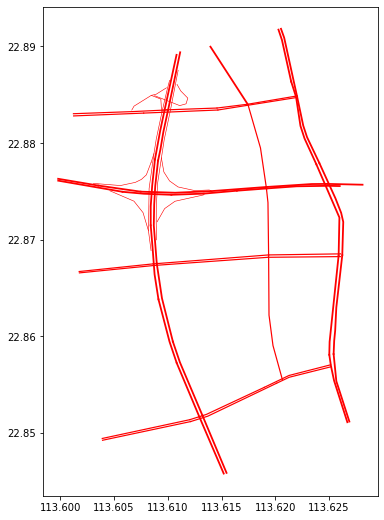

In [ ]:
fig = plt.figure(figsize=(6, 9))
for link in used_links.values():
    xs, ys = wkt.loads(link.shape).xy
    if len(link_corr_list[link.id - 1]) != 0:
        plt.plot(xs, ys, color='red', linewidth=(4-link.road_class)*0.6, zorder=1)
    else:
        plt.plot(xs, ys, color='grey', linewidth=(4-link.road_class)*0.6, zorder=1)

### Risk Feature

#### Time Index

In [ ]:
events = pd.read_csv(f'{path}link_id/total_linkid_all_new.csv', header=0, index_col=0)
events['link_id'] = events['link_id'].apply(lambda x:x[1:])
events_eff = events[events['link_id'] != 'None']
events_eff['time_index'] = events_eff['时间'].apply(lambda x: judge_time_index(int(x[11:13]), int(x[14:16])))
events_group = events_eff.groupby(by=['link_id', 'date', 'time_index']).size().reset_index(name='count')
events_group = events_group.sort_values(by=['date', 'time_index'], ascending=True)

#### Raw Risk Feature

In [ ]:
# Raw DataFrame
id_list = list(used_links.keys())
date_list = []
time_index_list = []
link_id_list = []
for day in range(duration):
    now_date = start_date + timedelta(days=day)
    now_date = str(now_date)[:10]
    for time_index in range(int(24 * 60 / interval)):
        for link_id in id_list:
            link_id_list.append(str(link_id))
            date_list.append(now_date)
            time_index_list.append(time_index)
dict_raw = {
    'date': date_list,
    'time_index': time_index_list,
    'link_id': link_id_list
}
df_raw = pd.DataFrame(dict_raw)
# Merge
df = pd.merge(df_raw, events_group, on=['link_id', 'date', 'time_index'], how='left')
print(len(df) - len(df[df['count'].isnull()]), len(events_group))
# Fill NA
df = df.fillna(0)
df['link_id'] = df['link_id'].apply(lambda x: 'a' + str(x))
df.to_csv(f'{path}risk_raw.csv', index=False)

42013 42753


#### Risk Feature Reshape

In [ ]:
df = pd.read_csv(f'{path}risk_raw.csv', header=0)
df['link_id'] = df['link_id'].apply(lambda x: x[1:])
id_list = list(used_links.keys())
new_df = pd.DataFrame(data=None, columns=['date', 'time_index'] + id_list)
start_time = time.time()
for day in range(duration):
    now_date = start_date + timedelta(days=day)
    now_date = str(now_date)[:10]
    print('Processing Date {}'.format(now_date))
    for time_index in range(int(24 * 60 / interval)):
        result = [now_date, time_index]
        for link_id in id_list:
            count = search_count(day, link_id, time_index, df, id_list)
            result.append(count)
        new_df.loc[len(new_df)] = result
    now_time = time.time()
    eta = (now_time - start_time) * (duration - 1 - day) / (day + 1)
    print('Processed Date {}\tTime:{}s\tETA:{}s\n'.format(now_date, '%.2f' % (now_time - start_time), '%.2f' % eta))
new_df.columns = ['date', 'time_index'] + ['a' + str(link_id) for link_id in id_list]
new_df.to_csv(f'{path}risk.csv', index=False)

Processing Date 2023-12-26
Processed Date 2023-12-26	Time:0.52s	ETA:30.40s

Processing Date 2023-12-27
Processed Date 2023-12-27	Time:0.94s	ETA:27.33s

Processing Date 2023-12-28
Processed Date 2023-12-28	Time:1.50s	ETA:28.51s

Processing Date 2023-12-29
Processed Date 2023-12-29	Time:2.05s	ETA:28.76s

Processing Date 2023-12-30
Processed Date 2023-12-30	Time:2.64s	ETA:29.00s

Processing Date 2023-12-31
Processed Date 2023-12-31	Time:3.21s	ETA:28.85s

Processing Date 2024-01-01
Processed Date 2024-01-01	Time:3.84s	ETA:29.07s

Processing Date 2024-01-02
Processed Date 2024-01-02	Time:4.50s	ETA:29.23s

Processing Date 2024-01-03
Processed Date 2024-01-03	Time:5.07s	ETA:28.71s

Processing Date 2024-01-04
Processed Date 2024-01-04	Time:5.54s	ETA:27.69s

Processing Date 2024-01-05
Processed Date 2024-01-05	Time:5.97s	ETA:26.61s

Processing Date 2024-01-06
Processed Date 2024-01-06	Time:6.36s	ETA:25.43s

Processing Date 2024-01-07
Processed Date 2024-01-07	Time:6.76s	ETA:24.42s

Processing D

### Speed Feature

#### Data Preprocessing

In [ ]:
speed_df = pd.read_table('../data/sf_0418/东莞高德数据/tb_state_dongguan.txt', sep=',')
speed_df.columns = ['date', 'link_id', 'speeds']  # link_ids are all in the provided links
speed_df['date'] = speed_df['date'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[-2:])
# link_ids are not identically ordered within each day (1665 links / day)
# In each day, 105 fixed links don't have speed data(w.r.t. used_links)!
id_list = list(used_links.keys())
length = len(id_list)
need_links = []
for item in link_corr_list:
    for link_id in item:
        need_links.append(link_id)
need_links = list(set(need_links))
df = pd.DataFrame(None, columns=['date', 'time_index'] + need_links)
date_list = []
index_list = []
for day in range(duration):
    now_date = start_date + timedelta(days=day)
    now_date = str(now_date)[:10]
    for index in range(int(24 * 60 / interval)):
        date_list.append(now_date)
        index_list.append(index)
df['date'] = date_list
df['time_index'] = index_list
now_date = ''
day = -1
print('Start!')
start_time = time.time()
for i in range(len(speed_df)):
    link_id = speed_df['link_id'].iloc[i]
    if str(link_id) not in need_links:
        continue
    date = speed_df['date'].iloc[i]
    if date not in date_list:
        continue
    if date != now_date:
        if day != -1:
            now_time = time.time()
            eta = (now_time - start_time) * (duration - 1 - day) / (day + 1)
            print('Processed Date {}\tTime:{}s\tETA:{}s\n'.format(now_date, '%.2f' % (now_time - start_time), '%.2f' % eta))
        now_date = date
        day += 1
        print('Processing {} (Day {})'.format(date, day))
    d = math.floor(i / 1665)
    speeds = [int(speed) for speed in speed_df['speeds'].iloc[i].split(';')]
    index_list = []
    for index, speed in enumerate(speeds):
        index_list.append(math.floor(index / interval))
    sub_df = pd.DataFrame({'time_index': index_list, 'speed': speeds}).groupby(by=['time_index']).agg('mean')
    if len(sub_df) != int(24 * 60 / interval):
        continue
    for j in sub_df.index:
        ind = int(day * 24 * 60 / interval) + j
        df[str(link_id)].iloc[ind] = round(sub_df['speed'].iloc[j], 2)
df.columns = ['date', 'time_index'] + ['a' + str(link_id) for link_id in need_links]
df.to_csv(f'{path}speed_raw.csv', index=False)

Start!
Processing 2023-12-26 (Day 0)
Processed Date 2023-12-26	Time:4.60s	ETA:271.12s

Processing 2023-12-27 (Day 1)
Processed Date 2023-12-27	Time:8.39s	ETA:243.18s

Processing 2023-12-28 (Day 2)
Processed Date 2023-12-28	Time:12.83s	ETA:243.80s

Processing 2023-12-29 (Day 3)
Processed Date 2023-12-29	Time:17.14s	ETA:240.01s

Processing 2023-12-30 (Day 4)
Processed Date 2023-12-30	Time:21.05s	ETA:231.52s

Processing 2023-12-31 (Day 5)
Processed Date 2023-12-31	Time:24.92s	ETA:224.32s

Processing 2024-01-01 (Day 6)
Processed Date 2024-01-01	Time:28.75s	ETA:217.65s

Processing 2024-01-02 (Day 7)
Processed Date 2024-01-02	Time:32.60s	ETA:211.89s

Processing 2024-01-03 (Day 8)
Processed Date 2024-01-03	Time:36.91s	ETA:209.14s

Processing 2024-01-04 (Day 9)
Processed Date 2024-01-04	Time:41.43s	ETA:207.13s

Processing 2024-01-05 (Day 10)
Processed Date 2024-01-05	Time:45.78s	ETA:203.91s

Processing 2024-01-06 (Day 11)
Processed Date 2024-01-06	Time:49.66s	ETA:198.63s

Processing 2024-01-07

#### Ordinary Cases

In [ ]:
speed_df = pd.read_csv(f'{path}speed_raw.csv', header=0)
speed_df.columns = ['date', 'time_index'] + [link_id[1:] for link_id in speed_df.columns[2:]]
df = pd.DataFrame(None, columns=['date', 'time_index'] + ['a' + str(i) for i in used_links.keys()])
df['date'] = speed_df['date']
df['time_index'] = speed_df['time_index']
for i in range(len(used_links)):
    corr_links = link_corr_list[i]
    link_id = 'a' + str(used_links[i + 1].id)
    df[link_id] = speed_df[corr_links].apply('mean', axis=1)
df.to_csv(f'{path}speed_raw_0.csv', index=False)

#### Missing Values
Special Case:
{
    'date': '2024-03-02~2024-03-10'
}

In [ ]:
# Preprocessing: filling recent missing values
speed_raw = pd.read_csv(f'{path}speed_raw_0.csv', header=0)
columns_list = speed_raw.columns[2:]
speed_raw.columns = ['date', 'time_index'] + [x[1:] for x in columns_list]
number = int(24 * 60 / interval)
# for day in range(duration - 9, duration):
#     speed_raw.iloc[day * number:(day + 1) * number, 2:] = speed_raw.iloc[(day - 7) * number:(day - 6) * number, 2:]
# Processing mean values
link_ids_with = []
speed_dict = speed_raw.isnull().any(axis=0).to_dict()
for link_id in list(used_links.keys()):
    if speed_dict[str(link_id)] == False:
        link_ids_with.append(str(link_id))
with_columns = ['date', 'time_index'] + link_ids_with
speed_with = speed_raw[with_columns]
speed_with['mean_speed'] = speed_with.apply(lambda x: round(np.mean(x[2:]), 2), axis=1)
speed_mean = speed_with[['date', 'time_index', 'mean_speed']]
# All missing links
all_missing_links = speed_raw.columns[speed_raw.isnull().all(axis=0)]
print('All Missing:', len(all_missing_links))
for link_id in all_missing_links:
    speed_raw[link_id] = speed_mean['mean_speed']
# Partial missing links
partial_missing_links = speed_raw.columns[speed_raw.isnull().any(axis=0)]
print('Partial Missing:', len(partial_missing_links))
for link_id in partial_missing_links:
    missing_indexes = list(speed_raw.index[speed_raw[link_id].isnull()])
    speed_raw[link_id].loc[missing_indexes] = speed_mean['mean_speed'].loc[missing_indexes]
# Check missing values
print('\nChecking:', speed_raw.iloc[speed_raw.index[speed_raw.isnull().any(axis=1)], :])
speed_raw.columns = ['date', 'time_index'] + columns_list.to_list()
speed_raw.to_csv(f'{path}speed.csv', index=False)

All Missing: 4
Partial Missing: 5

Checking: Empty DataFrame
Columns: [date, time_index, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]
Index: []

[0 rows x 72 columns]


#### Speed Data Analysis

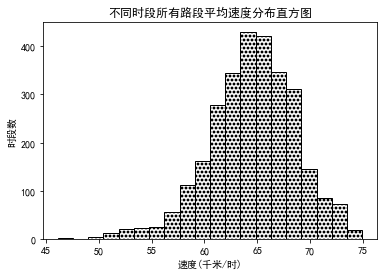

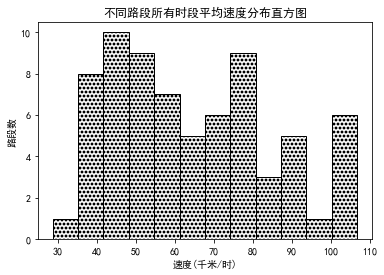

In [116]:
df = pd.read_csv(f'{path}speed.csv', header=0)
speeds = df.iloc[:, 2:].apply('mean', axis=1).to_list()
speeds = [round(speed, 2) for speed in speeds]
plt.hist(speeds, 20, color='w', edgecolor='k', hatch=r'ooo')
plt.title('不同时段所有路段平均速度分布直方图')
plt.xlabel('速度(千米/时)')
plt.ylabel('时段数')
plt.show()
speeds = df.iloc[:, 2:].apply('mean', axis=0).to_list()
speeds = [round(speed, 2) for speed in speeds]
plt.hist(speeds, 12, color='w', edgecolor='k', hatch=r'ooo')
plt.title('不同路段所有时段平均速度分布直方图')
plt.xlabel('速度(千米/时)')
plt.ylabel('路段数')
plt.show()

### Road Feature

In [ ]:
# Read Lanes & Class
t = pd.read_table(f'{path}road_network.txt', sep='@')
# Read Others
df = pd.read_csv(f'{path}adjacency.csv', header=0, index_col=0)
neighbor_list = list(df.apply(lambda x: sum(x), axis=1))
length_list = [round(link_length(link), 2) for link in used_links.values()]
id_list = [link.id for link in used_links.values()]
df_new = pd.DataFrame(data=None, columns=['Attribute'] + ['a' + str(link_id) for link_id in id_list])
df_new.loc[len(df_new)] = ['Neighbors'] + neighbor_list
df_new.loc[len(df_new)] = ['Length'] + length_list
df_new.loc[len(df_new)] = ['Lanes'] + t['lanes'].to_list()
df_new.loc[len(df_new)] = ['Class'] + t['linkclass'].to_list()
df_new.to_csv(f'{path}road.csv')

### Calendar Feature

#### Regular Calendar

In [ ]:
id_list = list(used_links.keys())
df = pd.DataFrame(data=None, columns=['location', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 'date', 'time_index', 'holiday'])
columns = df.columns.to_list()
zeros = [0] * len(id_list) * duration * int(60 * 24 / interval)
date_list = []
time_index_list = []
for day in range(duration):
    now_date = start_date + timedelta(days=day)
    now_date = str(now_date)[:10]
    for index in range(int(24 * 60 / interval)):
        date_list.append(now_date)
        time_index_list.append(index)
date_list *= len(id_list)
time_index_list *= len(id_list)
location_list = []
for link_id in id_list:
    for i in range(duration * int(60 * 24 / interval)):
        location_list.append('a' + str(link_id))
df['location'] = location_list
for i in range(1, 8):
    df[columns[i]] = zeros
df['date'] = date_list
df['time_index'] = time_index_list
df['holiday'] = zeros
start_time = time.time()
for i in range(len(id_list)):
    offset = i * duration * int(60 * 24 / interval)
    for day in range(duration):
        now_date = start_date + timedelta(days=day)
        now_day = now_date.weekday()
        start_index = offset + day * int(60 * 24 / interval)
        df[columns[now_day + 1]].iloc[start_index:(start_index + int(60 * 24 / interval))] = [1] * int(60 * 24 / interval)
    end_time = time.time()
    print(f'{i + 1}/{len(id_list)}', end_time - start_time, '\n')
df.to_csv(f'{path}calendar.csv', index=False)

1/70 0.030022382736206055 

2/70 0.05502462387084961 

3/70 0.08002376556396484 

4/70 0.10686564445495605 

5/70 0.13686394691467285 

6/70 0.1638646125793457 

7/70 0.1918802261352539 

8/70 0.22214865684509277 

9/70 0.24614906311035156 

10/70 0.2761547565460205 

11/70 0.30545687675476074 

12/70 0.3385434150695801 

13/70 0.36936378479003906 

14/70 0.39632415771484375 

15/70 0.42531371116638184 

16/70 0.45677924156188965 

17/70 0.48994970321655273 

18/70 0.5186128616333008 

19/70 0.544607400894165 

20/70 0.569608211517334 

21/70 0.6019840240478516 

22/70 0.637500524520874 

23/70 0.6694986820220947 

24/70 0.7025110721588135 

25/70 0.7330296039581299 

26/70 0.7640273571014404 

27/70 0.7950379848480225 

28/70 0.8299453258514404 

29/70 0.8609118461608887 

30/70 0.8919520378112793 

31/70 0.9204602241516113 

32/70 0.9524614810943604 

33/70 0.9764587879180908 

34/70 1.0090086460113525 

35/70 1.036973476409912 

36/70 1.0630097389221191 

37/70 1.0889763832092285 



#### Holiday Processing

In [ ]:
df = pd.read_csv(f'{path}calendar.csv', header=0)
df['holiday'] = df['date'].apply(lambda x: judge_holiday(x))
df.to_csv(f'{path}calendar.csv', index=False)

### Weather Feature

#### Raw Weather Data Collecting Function

In [ ]:
def weather(lon, lat, date_str):
  url = 'http://api.k780.com'
  params = {
    'app' : 'weather.history',
    'wgs84ll' : str(lon) + ',' + str(lat),
    'dateYmd' : date_str,
    'appkey' : '72937',
    'sign' : '6f9541ceddca3c3d61204ea04679402b',
    'format' : 'json',
  }
  params = urlencode(params)
  res = requests.get('%s?%s' % (url, params))
  ans = json.loads(res.text)
  if ans['success'] != '1':
    print(f'Error in ({lon},{lat})!')
    print(ans)
    return None
  ans = ans['result']['dtList']
  times = [x['upTime'] for x in ans]
  dates = [str(x)[:10] for x in times]
  timeindexes = [judge_time_index(int(x[11:13]), int(x[14:16])) for x in times]
  temps = [x['wtTemp'] for x in ans]
  humis = [x['wtHumi'] for x in ans]
  winds = [x['wtWins'] for x in ans]
  aqis = [x['wtAqi'] for x in ans]
  visis = [x['wtVisibility'] for x in ans]
  rains = [x['wtRainfall'] for x in ans]
  lons = [lon] * len(times)
  lats = [lat] * len(times)
  df_dict = {
      'date': dates,
      'timeIndex': timeindexes,
      'lon': lons,
      'lat': lats,
      'temperature': temps,
      'humidity': humis,
      'windspeed': winds,
      'airquality': aqis,
      'visibility': visis,
      'rain': rains
  }
  df = pd.DataFrame(df_dict)
  return df

#### Collecting Raw Weather Data

In [ ]:
processed = len(os.listdir(f'{path}/weather_raw'))
for i, lon in enumerate(grid_lons):
    for j, lat in enumerate(grid_lats):
        now = i * len(grid_lats) + j + 1
        if now <= processed: 
            continue
        print(f'Processing ({lon}, {lat}) {now}')
        df = pd.concat([weather(lon, lat, '20231226-20231231'), weather(lon, lat, '20240101-20240223')])
        df.to_csv(f'{path}weather_raw/{lon}&{lat}.csv')

Processing (113.625, 22.87) 13
Processing (113.625, 22.88) 14
Processing (113.625, 22.89) 15


#### Processing Raw Weather Data

In [ ]:
def process_weather(lon, lat):
    df = pd.read_csv(f'{path}weather_raw/{lon}&{lat}.csv', header=0, index_col=0)
    df = df.groupby(by=['date', 'timeIndex'], as_index=False, group_keys=False).agg('mean')
    dates = []
    timeindexes = []
    for day in range(duration):
        now_date = start_date + timedelta(days=day)
        now_date = str(now_date)[:10]
        dates += [now_date] * int(24 * 60 / interval)
        for i in range(int(24 * 60 / interval)):
            timeindexes.append(i)
    date_dict = {
        'date': dates,
        'timeIndex': timeindexes
    }
    date_df = pd.DataFrame(date_dict)
    new_df = pd.merge(date_df, df, how='left', on=['date', 'timeIndex'])
    new_df['lon'] = new_df['lon'].fillna(value=np.mean(new_df['lon']))
    new_df['lat'] = new_df['lat'].fillna(value=np.mean(new_df['lat']))
    indexes = new_df[new_df.isnull().any(axis=1)].index
    for i in indexes:
        # date, index = new_df['date'].iloc[i], new_df['timeIndex'].iloc[i]
        # sub_df = new_df[new_df['date'] == date]
        # index_first = sub_df.index[0]
        # j = i - index_first
        if i > 0 and i < len(new_df) - 1 and True not in new_df.iloc[i - 1, :].isnull().to_list() and True not in new_df.iloc[i + 1, :].isnull().to_list():
            for col in ['temperature', 'humidity', 'windspeed', 'airquality', 'visibility', 'rain']:
                new_df[col].iloc[i] = np.mean(new_df[col].iloc[[i - 1, i + 1]])
        elif i > 0 and True not in new_df.iloc[i - 1, :].isnull().to_list():
            for col in ['temperature', 'humidity', 'windspeed', 'airquality', 'visibility', 'rain']:
                new_df[col].iloc[i] = new_df[col].iloc[i - 1]
        elif i < len(new_df) - 1 and True not in new_df.iloc[i + 1, :].isnull().to_list():
            for col in ['temperature', 'humidity', 'windspeed', 'airquality', 'visibility', 'rain']:
                new_df[col].iloc[i] = new_df[col].iloc[i + 1]
        else:
            print('Error!', i, new_df.iloc[i, :])
    new_df['lon'] = new_df['lon'].apply(lambda x:round(x, 3))
    new_df['lat'] = new_df['lat'].apply(lambda x:round(x, 2))
    print(f'({lon},{lat})', new_df[new_df.isnull().any(axis=1)].index, '\n')
    new_df.to_csv(f'{path}weather/{lon}&{lat}.csv', index=False)

In [ ]:
for lon in grid_lons:
    for lat in grid_lats:
        print(f'Processing ({lon}, {lat})')
        process_weather(lon, lat)

Processing (113.605, 22.85)
(113.605,22.85) Int64Index([], dtype='int64') 

Processing (113.605, 22.86)
(113.605,22.86) Int64Index([], dtype='int64') 

Processing (113.605, 22.87)
(113.605,22.87) Int64Index([], dtype='int64') 

Processing (113.605, 22.88)
(113.605,22.88) Int64Index([], dtype='int64') 

Processing (113.605, 22.89)
(113.605,22.89) Int64Index([], dtype='int64') 

Processing (113.615, 22.85)
(113.615,22.85) Int64Index([], dtype='int64') 

Processing (113.615, 22.86)
(113.615,22.86) Int64Index([], dtype='int64') 

Processing (113.615, 22.87)
(113.615,22.87) Int64Index([], dtype='int64') 

Processing (113.615, 22.88)
(113.615,22.88) Int64Index([], dtype='int64') 

Processing (113.615, 22.89)
(113.615,22.89) Int64Index([], dtype='int64') 

Processing (113.625, 22.85)
(113.625,22.85) Int64Index([], dtype='int64') 

Processing (113.625, 22.86)
(113.625,22.86) Int64Index([], dtype='int64') 

Processing (113.625, 22.87)
(113.625,22.87) Int64Index([], dtype='int64') 

Processing (

#### Determine Links' Weather Data

In [ ]:
new_df = None
for ind, link in enumerate(used_links.values()):
    print(f'{ind + 1}/{len(used_links)}\n')
    ind_i, ind_j = 0, 0
    dist_min = np.inf
    link_id = 'a' + str(link.id)
    for i in range(len(grid_lons)):
        for j in range(len(grid_lats)):
            dist = get_dist(grid_lons[i], grid_lats[j], link)
            if dist < dist_min:
                dist_min = dist
                ind_i, ind_j = i, j
    lon, lat = grid_lons[ind_i], grid_lats[ind_j]
    df = pd.read_csv(f'{path}weather/{lon}&{lat}.csv', header=0).drop(columns=['lon', 'lat'])
    df.insert(loc=2, column='link_id', value=[link_id] * len(df))
    new_df = pd.concat([new_df, df])
new_df.to_csv(f'{path}weather.csv', index=False)

1/70

2/70

3/70

4/70

5/70

6/70

7/70

8/70

9/70

10/70

11/70

12/70

13/70

14/70

15/70

16/70

17/70

18/70

19/70

20/70

21/70

22/70

23/70

24/70

25/70

26/70

27/70

28/70

29/70

30/70

31/70

32/70

33/70

34/70

35/70

36/70

37/70

38/70

39/70

40/70

41/70

42/70

43/70

44/70

45/70

46/70

47/70

48/70

49/70

50/70

51/70

52/70

53/70

54/70

55/70

56/70

57/70

58/70

59/70

60/70

61/70

62/70

63/70

64/70

65/70

66/70

67/70

68/70

69/70

70/70



## Data Loader

### Normalize Function

In [4]:
def normalize(train, test):
    scaler = MinMaxScaler()
    train_shape, test_shape = train.shape, test.shape  # 之后train和test变化，还需要变回原来的shape
    train = scaler.fit_transform(train.reshape(-1, train.shape[-1]))  # 前一个-1表示模糊控制，后一个-1表示shape的最后一个元素
    test = scaler.transform(test.reshape(-1, test.shape[-1]))
    return train.reshape(train_shape), test.reshape(test_shape), scaler

### Data Loader Function

In [5]:
def data_loader(days, length, n_steps, train_ratio=0.8):
# risk data
    risk_data = pd.read_csv(f'{path}risk.csv', header=0)
    id_list = list(risk_data.columns)[2:]
    risk_data.columns = ['date', 'time_index'] + [int(link_id[1:]) for link_id in id_list]
    dates = risk_data['date'].to_list()
    timeindexes = risk_data['time_index'].to_list()
    link_ids = risk_data.drop(columns=['date', 'time_index']).columns
    risk_data = risk_data.drop(columns=['date', 'time_index'])
    n_links, n_outputs = len(link_ids), len(link_ids)
    number = int(24 * 60 / interval)
    total = number * days

    risk, y = [], []
    for i in range(int(24 * 60 / interval) + length, total - n_steps):
        if judge_holiday(dates[i]) == 0 and timeindexes[i - length] * interval / 60 >= 6 and 0 < timeindexes[i + n_steps - 1] * interval / 60 <= 22 and timeindexes[i] * interval / 60 >= 6:
            risk.append(risk_data.iloc[i - length:i, :n_links].to_numpy().astype('int8'))
            y.append(risk_data.iloc[i:i + n_steps, :n_outputs].to_numpy().astype('int8'))

    train_length = math.floor(len(risk) * train_ratio)
    risk_train, risk_test, y_train, y_test = risk[:train_length], risk[train_length:], y[:train_length], y[train_length:]
    risk_train, risk_test, risk_scaler = normalize(np.array(risk_train), np.array(risk_test))
    y_train, y_test = np.array(y_train), np.array(y_test)
    y_train_scaled, y_test_scaled, y_scaler = normalize(y_train, y_test)

    # road data
    road_data = pd.read_csv(f'{path}road.csv', header=0, index_col=0).drop(columns=['Attribute'])
    road_data.columns = [int(link_id[1:]) for link_id in id_list]
    link_road = []
    for link in link_ids:
        link_road.append(road_data[link].to_numpy())
    road_train, road_test = [np.array([link_road]*length)] * train_length, [np.array([link_road]*length)] * (len(risk) - train_length)
    road_train, road_test, _ = normalize(np.array(road_train), np.array(road_test))

    # weather data
    weather_data = pd.read_csv(f'{path}weather.csv', header=0)
    weather_data['link_id'] = weather_data['link_id'].apply(lambda x:int(x[1:]))
    link_weather = []
    for link in link_ids:
        link_weather.append(weather_data[weather_data['link_id'] == int(link)].iloc[:, 3:].to_numpy())
    link_weather = np.concatenate(link_weather, axis=1)
    weather = []

    for i in range(int(24 * 60 / interval) + length, total - n_steps):
        if judge_holiday(dates[i]) == 0 and timeindexes[i - length] * interval / 60 >= 6 and 0 < timeindexes[i + n_steps - 1] * interval / 60 <= 22 and timeindexes[i] * interval / 60 >= 6:
            weather.append(link_weather[i - length:i])
    
    weather_train, weather_test = weather[:train_length], weather[train_length:]
    weather_train, weather_test = np.array(weather_train), np.array(weather_test)
    weather_train, weather_test, _ = normalize(weather_train.reshape(weather_train.shape[0], weather_train.shape[1], n_links, -1), weather_test.reshape(weather_test.shape[0], weather_test.shape[1], n_links, -1))

    # speed data
    speed_data = pd.read_csv(f'{path}speed.csv', header=0).drop(columns=['date', 'time_index'])
    speed_data.columns = [int(link_id[1:]) for link_id in id_list]
    speed = []

    for i in range(int(24 * 60 / interval) + length, total - n_steps):
        if judge_holiday(dates[i]) == 0 and timeindexes[i - length] * interval / 60 >= 6 and 0 < timeindexes[i + n_steps - 1] * interval / 60 <= 22 and timeindexes[i] * interval / 60 >= 6:
            speed.append(speed_data.iloc[i - length:i, :n_links].to_numpy())

    speed_train, speed_test = speed[:train_length], speed[train_length:]
    speed_train, speed_test, _ = normalize(np.array(speed_train), np.array(speed_test))

    # calendar data
    calendar_data = pd.read_csv(f'{path}calendar.csv', header=0)
    calendar_data['date'] = calendar_data['date'].apply(lambda x:(datetime.strptime(x, '%Y-%m-%d') - start_date).days + 1)
    calendar_data['location'] = calendar_data['location'].apply(lambda x:int(x[1:]))
    calendar_train, calendar_test = [], []

    link_calendar = []
    for link in link_ids:
        link_calendar.append(calendar_data[calendar_data['location'] == int(link)].iloc[:, 1:].to_numpy())
    link_calendar = np.concatenate(link_calendar, axis=1)
    calendar = []

    for i in range(int(24 * 60 / interval) + length, total - n_steps):
        if judge_holiday(dates[i]) == 0 and timeindexes[i - length] * interval / 60 >= 6 and 0 < timeindexes[i + n_steps - 1] * interval / 60 <= 22 and timeindexes[i] * interval / 60 >= 6:
            calendar.append(link_calendar[i - length:i])
    
    calendar_train, calendar_test = calendar[:train_length], calendar[train_length:]
    calendar_train, calendar_test = np.array(calendar_train), np.array(calendar_test)
    calendar_train, calendar_test, _ = normalize(calendar_train.reshape(calendar_train.shape[0], calendar_train.shape[1], n_links, -1), calendar_test.reshape(calendar_test.shape[0], calendar_test.shape[1], n_links, -1))

    # Time Period
    risk_data = pd.read_csv(f'{path}risk.csv', header=0)
    id_list = list(risk_data.columns)[2:]
    risk_data.columns = ['date', 'time_index'] + [int(link_id[1:]) for link_id in id_list]
    time = []
    for i in range(int(24 * 60 / interval) + length, total - n_steps):
        if judge_holiday(dates[i]) == 0 and timeindexes[i - length] * interval / 60 >= 6 and 0 < timeindexes[i + n_steps - 1] * interval / 60 <= 22 and timeindexes[i] * interval / 60 >= 6:
            start = risk_data['date'].iloc[i - length] + ' ' + inverse_time(risk_data['time_index'].iloc[i - length])
            end = risk_data['date'].iloc[i] + ' ' + inverse_time(risk_data['time_index'].iloc[i])
            text = 'From ' + start + ' To ' + end
            time.append(text)

    time_train, time_test = time[:train_length], time[train_length:]

    # Match Shape
    risk_train = risk_train[:, :, :, None]
    risk_test = risk_test[:, :, :, None]
    speed_train = speed_train[:, :, :, None]
    speed_test = speed_test[:, :, :, None]

    return{
        'risk': [risk_train, risk_test],
        'road': [road_train, road_test],
        'calendar': [calendar_train, calendar_test],
        'speed': [speed_train, speed_test],
        'weather': [weather_train, weather_test],
        'y': [y_train, y_test], 
        'y_scaled': [y_train_scaled, y_test_scaled],
        'selected_links': link_ids,
        'scaler': risk_scaler,
        'timePeriods': [time_train, time_test]
    }

## Graph Construction

### Degree Data

In [ ]:
A = pd.read_csv(f'{path}adjacency.csv', index_col=0)
D = np.zeros(A.shape, dtype=int)
print(A.shape[0])
for i in range(A.shape[0]):
    D[i][i] = np.sum(np.array(A), axis=1)[i]
pd.DataFrame(D, columns=A.columns.to_list(), index=A.columns.to_list()).to_csv(f'{path}degree.csv')

70


### Data Normalization

In [ ]:
A = pd.read_csv(f'{path}adjacency.csv', index_col=0)
D = pd.read_csv(f'{path}degree.csv', index_col=0)
columns = A.columns.to_list()
A, D = np.array(A), np.array(D)
L = np.dot(np.dot(np.linalg.inv(np.sqrt(D)), A), np.linalg.inv(np.sqrt(D)))
pd.DataFrame(L, index=columns, columns=columns).to_csv(f'{path}normalized.csv')

### Multi-View Graph Construction

#### Generate Matrix

In [ ]:
def generate_matrix(data, name, metric=distance.jaccard):
    As = pd.read_csv(f'{path}adjacency.csv', index_col=0)
    n_links = len(As.columns)

    A = np.zeros([n_links, n_links])
    for i in range(n_links):
        for j in range(n_links):
            u, v = data[:, i], data[:, j]
            A[i][j] = 1 - metric(u, v)

    avg = np.average(A)
    # scale = 0.5  # 0.25/1/2/4
    eps = avg * scale
    for i in range(n_links):
        for j in range(n_links):
            A[i][j] = 1 if A[i][j] >= eps else 0
    
    D = np.zeros(A.shape, dtype=int)
    for i in range(A.shape[0]):
        D[i][i] = np.sum(np.array(A), axis=1)[i]

    columns = As.columns.to_list()
    L = np.dot(np.dot(np.linalg.inv(np.sqrt(D)), A), np.linalg.inv(np.sqrt(D)))
    pd.DataFrame(L, index=columns, columns=columns).to_csv(f'{path}{name}_graph.csv')

#### Matrix Processing

In [ ]:
A = pd.read_csv(f'{path}adjacency.csv', index_col=0)
road_data = pd.read_csv(f'{path}road.csv', index_col=0).drop(columns=['Attribute'])[A.columns].to_numpy()
generate_matrix(MinMaxScaler().fit_transform(road_data), 'road')

#### Traffic Array Processing

In [ ]:
A = pd.read_csv(f'{path}adjacency.csv', index_col=0)
risk_data = pd.read_csv(f'{path}risk.csv')[A.columns].to_numpy()
speed_data = pd.read_csv(f'{path}speed.csv').drop(columns=['date', 'time_index'])[A.columns].to_numpy()
speed_data = MinMaxScaler().fit_transform(speed_data)
link_ids = A.columns.to_list()
n_links = len(link_ids)
traffic_data = np.zeros([risk_data.shape[0], n_links, 1])
number = int(24 * 60 / interval) * duration
A_traffic = np.zeros([number, n_links, n_links], dtype='float16')  # 24hour/day * 7day = 168

for t in range(number):
    for i, link_id_i in enumerate(link_ids):
        traffic_data[t][i] = [speed_data[t][i]]
print('Phase 1!')

start = time.time()
for t in range(number):
    for i, link_id_i in enumerate(link_ids):
        for j, link_id_j in enumerate(link_ids):
            ut, vt = traffic_data[t][i], traffic_data[t][j]
            A_traffic[t][i][j] = 1 - abs(ut - vt)
    avg = np.average(A_traffic[t])
    eps = avg * scale
    for i, link_id_i in enumerate(link_ids):
        for j, link_id_j in enumerate(link_ids):
            A_traffic[t][i][j] = 1 if A_traffic[t][i][j] >= eps else 0
    end = time.time()
    print(f'{t + 1}/{number}')
print('Phase 2!')
# A_traffic.to_csv('../data/2023-11-23to2023-12-03/test_data/A_traffic.csv', index=False)
with open(f'{path}A_traffic.npy', 'wb') as f:
    np.save(f, A_traffic)

Phase 1!
1/2880
2/2880
3/2880
4/2880
5/2880
6/2880
7/2880
8/2880
9/2880
10/2880
11/2880
12/2880
13/2880
14/2880
15/2880
16/2880
17/2880
18/2880
19/2880
20/2880
21/2880
22/2880
23/2880
24/2880
25/2880
26/2880
27/2880
28/2880
29/2880
30/2880
31/2880
32/2880
33/2880
34/2880
35/2880
36/2880
37/2880
38/2880
39/2880
40/2880
41/2880
42/2880
43/2880
44/2880
45/2880
46/2880
47/2880
48/2880
49/2880
50/2880
51/2880
52/2880
53/2880
54/2880
55/2880
56/2880
57/2880
58/2880
59/2880
60/2880
61/2880
62/2880
63/2880
64/2880
65/2880
66/2880
67/2880
68/2880
69/2880
70/2880
71/2880
72/2880
73/2880
74/2880
75/2880
76/2880
77/2880
78/2880
79/2880
80/2880
81/2880
82/2880
83/2880
84/2880
85/2880
86/2880
87/2880
88/2880
89/2880
90/2880
91/2880
92/2880
93/2880
94/2880
95/2880
96/2880
97/2880
98/2880
99/2880
100/2880
101/2880
102/2880
103/2880
104/2880
105/2880
106/2880
107/2880
108/2880
109/2880
110/2880
111/2880
112/2880
113/2880
114/2880
115/2880
116/2880
117/2880
118/2880
119/2880
120/2880
121/2880
122/2880
1

#### Traffic Data For Training

In [ ]:
A_traffic = np.load(f'{path}A_traffic.npy')
pd.DataFrame(A_traffic[20]).to_csv(f'{path}speed_test.csv', index=False)

In [ ]:
# Read Data
A_traffic = np.load(f'{path}A_traffic.npy')
A = pd.read_csv(f'{path}adjacency.csv', index_col=0)
link_ids = [link_id[1:] for link_id in A.columns.to_list()]
n_links = len(link_ids)
A_traffic_train = []
number = int(24 * 60 / interval)
risk_data = pd.read_csv(f'{path}risk.csv', header=0)
dates = risk_data['date'].to_list()
timeindexes = risk_data['time_index'].to_list()
for i in range(int(24 * 60 / interval) + length, number * duration - n_steps):
    if judge_holiday(dates[i]) == 0 and timeindexes[i - length] * interval / 60 >= 6 and 0 < timeindexes[i + n_steps - 1] * interval / 60 <= 22 and timeindexes[i] * interval / 60 >= 6:
        A_traffic_train.append(A_traffic[i - length:i, :n_links])
train_length = math.floor(len(A_traffic_train) * train_ratio)
A_traffic_train = np.array(A_traffic_train[:train_length], dtype=float)
D_traffic_train = np.zeros(A_traffic_train.shape, dtype=float)
# Get D_traffic_train
start = time.time()
for t in range(A_traffic_train.shape[0]):
    for l in range(length):
        for i in range(n_links):
            D_traffic_train[t][l][i][i] = np.sum(np.array(A_traffic_train[t][l]), axis=1)[i]
    end = time.time()
    print(f'{t + 1}/{A_traffic_train.shape[0]}\t{round((end - start) * (A_traffic_train.shape[0] - t - 1) / (t + 1), 1)}s')
with open(f'{path}A_traffic_train.npy', 'wb') as f:
    np.save(f, A_traffic_train)
with open(f'{path}D_traffic_train.npy', 'wb') as f:
    np.save(f, D_traffic_train)

1/918	9.2s
2/918	6.1s
3/918	4.4s
4/918	3.3s
5/918	2.6s
6/918	3.6s
7/918	3.7s
8/918	3.5s
9/918	3.5s
10/918	3.3s
11/918	3.0s
12/918	3.4s
13/918	3.3s
14/918	3.3s
15/918	3.2s
16/918	3.0s
17/918	2.8s
18/918	3.1s
19/918	3.1s
20/918	3.1s
21/918	3.0s
22/918	2.8s
23/918	3.0s
24/918	3.0s
25/918	3.0s
26/918	2.9s
27/918	2.7s
28/918	3.0s
29/918	3.0s
30/918	2.9s
31/918	2.8s
32/918	2.7s
33/918	2.9s
34/918	2.9s
35/918	2.9s
36/918	2.8s
37/918	2.7s
38/918	2.9s
39/918	2.9s
40/918	2.9s
41/918	2.8s
42/918	2.7s
43/918	2.7s
44/918	2.8s
45/918	2.8s
46/918	2.8s
47/918	2.7s
48/918	2.7s
49/918	2.8s
50/918	2.8s
51/918	2.8s
52/918	2.8s
53/918	2.7s
54/918	2.7s
55/918	2.6s
56/918	2.7s
57/918	2.7s
58/918	2.7s
59/918	2.6s
60/918	2.6s
61/918	2.7s
62/918	2.7s
63/918	2.6s
64/918	2.6s
65/918	2.6s
66/918	2.6s
67/918	2.6s
68/918	2.7s
69/918	2.7s
70/918	2.6s
71/918	2.7s
72/918	2.7s
73/918	2.7s
74/918	2.7s
75/918	2.6s
76/918	2.6s
77/918	2.7s
78/918	2.7s
79/918	2.7s
80/918	2.6s
81/918	2.6s
82/918	2.6s
83/918	2.6s
84/918	2.6s
8

In [ ]:
A = np.load(f'{path}A_traffic_train.npy')
D = np.load(f'{path}D_traffic_train.npy')
# Get L
L = np.zeros(A.shape, dtype=float)
print(2)
start = time.time()
for t in range(A.shape[0]):
    for l in range(length):
        inv_D = np.linalg.inv(np.sqrt(D[t][l] + 0.0000001 * np.random.rand(D[t][l].shape[0], len(used_links))))
        L[t][l] = np.dot(np.dot(inv_D, A[t][1]), inv_D)
        end = time.time()
        print(t, l, round((end - start) / (t * length + l + 1) * (A.shape[0] * length - t * length - l - 1), 1), 's')
with open(f'{path}traffic_train.npy', 'wb') as f:
    np.save(f, L)

2
0 0 6.4 s
0 1 3.2 s
0 2 13.8 s
0 3 17.8 s
1 0 14.3 s
1 1 11.9 s
1 2 10.2 s
1 3 15.9 s
2 0 15.0 s
2 1 14.9 s
2 2 14.6 s
2 3 14.6 s
3 0 15.5 s
3 1 15.2 s
3 2 14.9 s
3 3 14.7 s
4 0 14.4 s
4 1 14.0 s
4 2 13.9 s
4 3 13.5 s
5 0 13.2 s
5 1 13.0 s
5 2 12.9 s
5 3 12.7 s
6 0 12.9 s
6 1 12.4 s
6 2 11.9 s
6 3 12.7 s
7 0 14.9 s
7 1 14.8 s
7 2 14.5 s
7 3 14.4 s
8 0 14.0 s
8 1 14.4 s
8 2 14.3 s
8 3 14.2 s
9 0 14.2 s
9 1 14.1 s
9 2 14.1 s
9 3 14.0 s
10 0 14.1 s
10 1 13.8 s
10 2 14.0 s
10 3 13.9 s
11 0 13.7 s
11 1 13.7 s
11 2 13.5 s
11 3 13.3 s
12 0 13.0 s
12 1 13.4 s
12 2 13.4 s
12 3 13.9 s
13 0 13.6 s
13 1 13.4 s
13 2 13.8 s
13 3 13.5 s
14 0 13.9 s
14 1 13.7 s
14 2 13.4 s
14 3 14.2 s
15 0 14.3 s
15 1 14.1 s
15 2 14.7 s
15 3 14.4 s
16 0 14.2 s
16 1 14.7 s
16 2 14.6 s
16 3 14.5 s
17 0 14.4 s
17 1 14.3 s
17 2 14.2 s
17 3 14.2 s
18 0 14.2 s
18 1 14.1 s
18 2 13.9 s
18 3 13.7 s
19 0 13.5 s
19 1 13.8 s
19 2 14.0 s
19 3 13.9 s
20 0 13.8 s
20 1 13.7 s
20 2 13.8 s
20 3 13.7 s
21 0 13.6 s
21 1 13.6 s
21 2 13.

In [ ]:
L

array([[[[ 3.11773169e-02,  3.16772941e-02,  3.11758299e-02, ...,
          -7.29937409e-05, -5.72367660e-05,  2.49307411e-02],
         [ 3.16774063e-02,  3.21854035e-02,  3.16762471e-02, ...,
          -7.23128434e-05, -5.91533574e-05,  2.53325038e-02],
         [ 3.11760526e-02,  3.16761800e-02,  3.11751389e-02, ...,
          -7.62328764e-05, -5.94274333e-05,  2.49298084e-02],
         ...,
         [-7.27483774e-05, -7.19542916e-05, -7.31762505e-05, ...,
           2.26578169e-02, -5.57341232e-05,  2.12519758e-02],
         [-5.66755630e-05, -5.97105376e-05, -5.66788258e-05, ...,
          -5.60286760e-05,  2.62780399e-02, -5.71253397e-05],
         [ 2.49259230e-02,  2.53300395e-02,  2.49270131e-02, ...,
           2.12517261e-02, -5.69906536e-05,  1.99324169e-02]],

        [[ 3.02344768e-02,  3.02369029e-02,  2.97893395e-02, ...,
          -6.38417612e-05, -7.21725695e-05,  2.53241941e-02],
         [ 3.02345967e-02,  3.02370229e-02,  2.97895878e-02, ...,
          -6.69439387e

#### Traffic Data For Testing

In [ ]:
# Read Data
A_traffic = np.load(f'{path}A_traffic.npy')
A = pd.read_csv(f'{path}adjacency.csv', index_col=0)
link_ids = [link_id[1:] for link_id in A.columns.to_list()]
n_links = len(link_ids)
A_traffic_test = []
number = int(24 * 60 / interval)
risk_data = pd.read_csv(f'{path}risk.csv', header=0)
dates = risk_data['date'].to_list()
timeindexes = risk_data['time_index'].to_list()
for i in range(int(24 * 60 / interval) + length, number * duration - n_steps):
    if judge_holiday(dates[i]) == 0 and timeindexes[i - length] * interval / 60 >= 6 and 0 < timeindexes[i + n_steps - 1] * interval / 60 <= 22 and timeindexes[i] * interval / 60 >= 6:
        A_traffic_test.append(A_traffic[i - length:i, :n_links])
train_length = math.floor(len(A_traffic_test) * train_ratio)
A_traffic_test = np.array(A_traffic_test[train_length:], dtype=float)
D_traffic_test = np.zeros(A_traffic_test.shape, dtype=float)
# Get D_traffic_test
start = time.time()
for t in range(A_traffic_test.shape[0]):
    for l in range(length):
        for i in range(n_links):
            D_traffic_test[t][l][i][i] = np.sum(np.array(A_traffic_test[t][l]), axis=1)[i]
    end = time.time()
    print(f'{t + 1}/{A_traffic_test.shape[0]}\t{round((end - start) * (A_traffic_test.shape[0] - t - 1) / (t + 1), 1)}s')
with open(f'{path}A_traffic_test.npy', 'wb') as f:
    np.save(f, A_traffic_test)
with open(f'{path}D_traffic_test.npy', 'wb') as f:
    np.save(f, D_traffic_test)

1/230	0.0s
2/230	0.0s
3/230	0.0s
4/230	0.6s
5/230	0.4s
6/230	0.4s
7/230	0.3s
8/230	0.6s
9/230	0.5s
10/230	0.4s
11/230	0.6s
12/230	0.5s
13/230	0.5s
14/230	0.5s
15/230	0.6s
16/230	0.5s
17/230	0.5s
18/230	0.6s
19/230	0.6s
20/230	0.5s
21/230	0.5s
22/230	0.6s
23/230	0.5s
24/230	0.5s
25/230	0.6s
26/230	0.6s
27/230	0.6s
28/230	0.6s
29/230	0.6s
30/230	0.6s
31/230	0.6s
32/230	0.6s
33/230	0.6s
34/230	0.6s
35/230	0.6s
36/230	0.6s
37/230	0.6s
38/230	0.6s
39/230	0.6s
40/230	0.6s
41/230	0.6s
42/230	0.6s
43/230	0.6s
44/230	0.6s
45/230	0.6s
46/230	0.6s
47/230	0.6s
48/230	0.6s
49/230	0.6s
50/230	0.6s
51/230	0.6s
52/230	0.6s
53/230	0.6s
54/230	0.6s
55/230	0.6s
56/230	0.6s
57/230	0.6s
58/230	0.6s
59/230	0.6s
60/230	0.6s
61/230	0.6s
62/230	0.6s
63/230	0.5s
64/230	0.5s
65/230	0.5s
66/230	0.5s
67/230	0.5s
68/230	0.5s
69/230	0.5s
70/230	0.5s
71/230	0.5s
72/230	0.5s
73/230	0.5s
74/230	0.5s
75/230	0.5s
76/230	0.5s
77/230	0.5s
78/230	0.5s
79/230	0.5s
80/230	0.5s
81/230	0.5s
82/230	0.5s
83/230	0.5s
84/230	0.5s
8

In [ ]:
A = np.load(f'{path}A_traffic_test.npy')
D = np.load(f'{path}D_traffic_test.npy')
# Get L
L = np.zeros(A.shape, dtype=float)
print(2)
start = time.time()
for t in range(A.shape[0]):
    for l in range(length):
        inv_D = np.linalg.inv(np.sqrt(D[t][l] + 0.0000001 * np.random.rand(D[t][l].shape[0], len(used_links))))
        L[t][l] = np.dot(np.dot(inv_D, A[t][1]), inv_D)
        end = time.time()
        print(t, l, round((end - start) / (t * length + l + 1) * (A.shape[0] * length - t * length - l - 1), 1), 's')
with open(f'{path}traffic_test.npy', 'wb') as f:
    np.save(f, L)

2
0 0 12.2 s
0 1 9.1 s
0 2 8.4 s
0 3 6.3 s
1 0 5.0 s
1 1 5.8 s
1 2 5.4 s
1 3 4.7 s
2 0 4.2 s
2 1 3.8 s
2 2 4.6 s
2 3 4.4 s
3 0 4.2 s
3 1 4.1 s
3 2 3.8 s
3 3 3.9 s
4 0 3.8 s
4 1 3.7 s
4 2 3.6 s
4 3 3.6 s
5 0 3.5 s
5 1 3.5 s
5 2 3.4 s
5 3 3.4 s
6 0 3.3 s
6 1 3.2 s
6 2 3.1 s
6 3 3.0 s
7 0 2.9 s
7 1 3.1 s
7 2 3.0 s
7 3 3.0 s
8 0 3.0 s
8 1 3.0 s
8 2 2.9 s
8 3 2.9 s
9 0 2.9 s
9 1 2.8 s
9 2 2.8 s
9 3 2.7 s
10 0 2.7 s
10 1 2.6 s
10 2 2.7 s
10 3 2.7 s
11 0 2.7 s
11 1 2.7 s
11 2 2.6 s
11 3 2.6 s
12 0 2.6 s
12 1 2.6 s
12 2 2.6 s
12 3 2.5 s
13 0 2.5 s
13 1 2.5 s
13 2 2.5 s
13 3 2.5 s
14 0 2.5 s
14 1 2.4 s
14 2 2.4 s
14 3 2.4 s
15 0 2.4 s
15 1 2.4 s
15 2 2.3 s
15 3 2.3 s
16 0 2.3 s
16 1 2.2 s
16 2 2.3 s
16 3 2.3 s
17 0 2.3 s
17 1 2.3 s
17 2 2.3 s
17 3 2.3 s
18 0 2.3 s
18 1 2.3 s
18 2 2.3 s
18 3 2.3 s
19 0 2.3 s
19 1 2.3 s
19 2 2.4 s
19 3 2.4 s
20 0 2.4 s
20 1 2.4 s
20 2 2.4 s
20 3 2.5 s
21 0 2.4 s
21 1 2.5 s
21 2 2.5 s
21 3 2.4 s
22 0 2.5 s
22 1 2.5 s
22 2 2.5 s
22 3 2.4 s
23 0 2.4 s
23 1 2.5 s
23 

In [ ]:
L

array([[[[ 2.37562750e-02, -6.49090341e-05, -7.75555074e-05, ...,
           2.13372393e-02, -1.27462167e-04,  2.13414221e-02],
         [-7.75803531e-05,  9.08619697e-02,  1.06545344e-01, ...,
          -9.10875065e-05, -1.87880720e-04, -8.17047747e-05],
         [-7.86496871e-05,  1.06549532e-01,  1.24948647e-01, ...,
          -9.82385933e-05, -2.07803133e-04, -9.02241387e-05],
         ...,
         [ 2.13384901e-02, -8.32915647e-05, -9.82421480e-05, ...,
           1.91676140e-02,  4.60946933e-02,  1.91710046e-02],
         [-1.38027894e-04, -1.79472998e-04, -1.99570051e-04, ...,
           4.60839676e-02,  1.10813557e-01,  4.60884117e-02],
         [ 2.13417949e-02, -7.64115683e-05, -8.90139144e-05, ...,
           1.91680867e-02,  4.60958965e-02,  1.91730317e-02]],

        [[ 2.69646906e-02, -1.02832552e-04, -1.23170771e-04, ...,
           2.25158433e-02, -6.79042981e-05,  2.36647956e-02],
         [-1.19115290e-04,  1.66563382e-01,  2.04002339e-01, ...,
          -1.24048849e

## Model Run

### Read Data & Train Model

In [7]:
best_config = [256, 128, 512, 4, False, 9]
best_config = [256, 512, 1024, 4, True, 9]
datasets = data_loader(duration, length=length, n_steps=n_steps)
n_links = len(datasets['selected_links'])
seed = np.random.randint(low=1, high=200)
print('Seed:', seed)
np.random.seed(50)

risk_train, risk_test = datasets['risk'][0], datasets['risk'][1]
road_train, road_test = datasets['road'][0], datasets['road'][1]
calendar_train, calendar_test = datasets['calendar'][0], datasets['calendar'][1]
speed_train, speed_test = datasets['speed'][0], datasets['speed'][1]
weather_train, weather_test = datasets['weather'][0], datasets['weather'][1]
y_train, y_test = datasets['y'][0], datasets['y'][1]
time_train, time_test = datasets['timePeriods'][0], datasets['timePeriods'][1]

val_idx = round(risk_train.shape[0] * 0.1)
risk_train, risk_val = risk_train[:-val_idx], risk_train[-val_idx:]
road_train, road_val = road_train[:-val_idx], road_train[-val_idx:]
calendar_train, calendar_val = calendar_train[:-val_idx], calendar_train[-val_idx:]
speed_train, speed_val = speed_train[:-val_idx], speed_train[-val_idx:]
weather_train, weather_val = weather_train[:-val_idx], weather_train[-val_idx:]
y_train, y_val = y_train[:-val_idx], y_train[-val_idx:]
time_train, time_val = time_train[:-val_idx], time_train[-val_idx:]

A = pd.read_csv(f'{path}normalized.csv', header=0, index_col=0).to_numpy()
A_road = pd.read_csv(f'{path}road_graph.csv', header=0, index_col=0).to_numpy()
A_train, A_val = np.tile(A, (risk_train.shape[0], 1, 1)), np.tile(A, (risk_val.shape[0], 1, 1))
A_road_train, A_road_val = np.tile(A_road, (risk_train.shape[0], 1, 1)), np.tile(A_road, (risk_val.shape[0], 1, 1))
A_test = np.tile(A, (risk_test.shape[0], 1, 1))
A_road_test = np.tile(A_road, (risk_test.shape[0], 1, 1))
with open(f'{path}traffic_train.npy', 'rb') as f:
    A_traffic_train = np.load(f)
    A_traffic_train, A_traffic_val = A_traffic_train[:-val_idx], A_traffic_train[-val_idx:]
with open(f'{path}traffic_test.npy', 'rb') as f:
    A_traffic_test = np.load(f)

node_features_train = np.concatenate([risk_train, road_train, speed_train, weather_train, calendar_train], axis=-1)
node_features_val = np.concatenate([risk_val, road_val, speed_val, weather_val, calendar_val], axis=-1)
node_features_test = np.concatenate([risk_test, road_test, speed_test, weather_test, calendar_test], axis=-1)

x_train = [A_train, A_road_train, A_traffic_train, node_features_train]
x_val = [A_val, A_road_val, A_traffic_val, node_features_val]
x_test = [A_test, A_road_test, A_traffic_test, node_features_test]

# shuffle
x = []
num_train, num_val, num_test = x_train[0].shape[0], x_val[0].shape[0], x_test[0].shape[0]
for i in range(4):
    x.append(np.concatenate([x_train[i], x_val[i], x_test[i]]))
y = np.concatenate([y_train, y_val, y_test])
times = np.concatenate([time_train, time_val, time_test])
calendar = np.concatenate([calendar_train, calendar_val, calendar_test])
ref = [i for i in range(y.shape[0])]
np.random.shuffle(ref)
x_0 = x
for i in range(4):
    for j in range(len(ref)):
        x_0[i][j] = x[i][ref[j]]
y_0 = y
for j in range(len(ref)):
    y_0[j] = y[ref[j]]
times_0 = times
for j in range(len(ref)):
    times_0[j] = times[ref[j]]
calendar_0 = calendar
for j in range(len(ref)):
    calendar_0[j] = calendar[ref[j]]
x_train, x_val, x_test = [], [], []
for i in range(4):
    x_train.append(x_0[i][:num_train])
    x_val.append(x_0[i][num_train:-num_test])
    x_test.append(x_0[i][-num_test:])
y_train, y_val, y_test = y_0[:num_train], y_0[num_train:-num_test], y_0[-num_test:]
time_train, time_val, time_test = times_0[:num_train], times_0[num_train:-num_test], times_0[-num_test:]
calendar_train, calendar_val, calendar_test = calendar_0[:num_train], calendar_0[num_train:-num_test], calendar_0[-num_test:]

print('Data Loaded!')
model, history = model(x_train, y_train, x_val, y_val, best_config, length=length, n_steps=n_steps)
print('Model Trained!')
# model.save(f'{path}model.keras')

Seed: 177
Data Loaded!

Epoch 1/100

26/26 [==============================] - 33s 417ms/step - loss: 1.2284 - val_loss: 1.0807
Epoch 2/100
26/26 [==============================] - 8s 311ms/step - loss: 1.0912 - val_loss: 1.0607
Epoch 3/100
26/26 [==============================] - 8s 290ms/step - loss: 1.0796 - val_loss: 1.0880
Epoch 4/100
26/26 [==============================] - 8s 303ms/step - loss: 1.0558 - val_loss: 1.0124
Epoch 5/100
26/26 [==============================] - 8s 306ms/step - loss: 1.0219 - val_loss: 1.0027
Epoch 6/100
26/26 [==============================] - 8s 326ms/step - loss: 1.0093 - val_loss: 1.0161
Epoch 7/100
26/26 [==============================] - 10s 376ms/step - loss: 0.9773 - val_loss: 0.9756
Epoch 8/100
26/26 [==============================] - 8s 326ms/step - loss: 0.9377 - val_loss: 0.9593
Epoch 9/100
26/26 [==============================] - 8s 309ms/step - loss: 0.9016 - val_loss: 0.9355
Epoch 10/100
26/26 [==============================] - 9s 336ms/s

In [120]:
model.save(f'{path}best_model.h5')

### Calculate Error

#### Default Situation

In [9]:
#model = tf.keras.models.load_model(f'{path}best_model.h5', custom_objects={'GCNConv':GCNConv, 'GlobalAvgPool':GlobalAvgPool, 'Transformer':Transformer})
y_pred = model.predict(x_train)
sw_errors = stepwise_error(y_train, y_pred, n_steps)
print('Model Performance(Train):')
print(f"MSE: {np.average(sw_errors['MSE'])} - Acc@K: {np.average(sw_errors['ACC'])} \n")

y_pred = model.predict(x_test)
sw_errors = stepwise_error(y_test, y_pred, n_steps)
print('Model Performance(Test):')
print(f"MSE: {np.average(sw_errors['MSE'])} - Acc@K: {np.average(sw_errors['ACC'])} \n")

26/26 [==============================] - 3s 109ms/step
Model Performance(Train):
MSE: 0.18940436840057373 - Acc@K: 0.8267734005301979 

8/8 [==============================] - 1s 99ms/step
Model Performance(Test):
MSE: 0.38351869583129883 - Acc@K: 0.7474833243935678 



#### Different Situation

In [ ]:
for x in x_test:
    print(x.shape)
print(model.summary())

(252, 70, 70)
(252, 70, 70)
(252, 4, 70, 70)
(252, 4, 70, 22)


AttributeError: 'function' object has no attribute 'summary'

In [ ]:
y_pred = model.predict(x_test)
for k in [0.03, 0.1, 0.15, 0.2, 0.25, 0.3]:
    sw_errors = stepwise_error(y_test, y_pred, n_steps, rate=k)
    print(k, f"MSE: {np.average(sw_errors['MSE'])} - Acc@{int(k*100)}%: {np.average(sw_errors['ACC'])} \n")

11/11 [==============================] - 19s 2s/step
0.03 MSE: 0.07414007186889648 - Acc@3%: 0.2980543493314391 

0.1 MSE: 0.07414007186889648 - Acc@10%: 0.5346294655601316 

0.15 MSE: 0.07414007186889648 - Acc@15%: 0.6606533710199964 

0.2 MSE: 0.07414007186889648 - Acc@20%: 0.739011210008524 

0.25 MSE: 0.07414007186889648 - Acc@25%: 0.7951205199247777 

0.3 MSE: 0.07414007186889648 - Acc@30%: 0.8398551847941809 



### Result Visualization

#### Generate Single Picture

In [23]:
def generate_pic(y, number, i, times, task):
    risks = list(y[number][i])
    max_risk = max(risks)
    for j in range(len(risks)):
        if risks[j] == 0:
            risks[j] = 1e-4
    norm = colors.LogNorm(vmin=1e-4, vmax=max_risk)
    cmap = plt.get_cmap('RdYlGn_r')
    fig = plt.figure(figsize=(6, 9))
    ax = plt.gca()
    for j, link in enumerate(used_links.values()):
        xs = [nodes[link.fnode].lon, nodes[link.tnode].lon]
        ys = [nodes[link.fnode].lat, nodes[link.tnode].lat]
        risk = risks[j]
        plt.plot(xs, ys, color=cmap((risk - min(risks)) / (max(risks) - min(risks))), linewidth=2 + (risk - min(risks)) / (max(risks) - min(risks)))
    fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), orientation='vertical', label='Risk Index (minmax-scale)', ax=ax)
    title = times[number] + '\n' + 'Predicting ' + str(datetime.strptime(times[number][25:], '%Y-%m-%d %H:%M') + timedelta(minutes=(i + 1) * interval))[:-3]
    if task == 'pred':
        title += '  Prediction'
    elif task == 'test':
        title += '  True Case'
    plt.title(title)
    

#### Generate GIFs

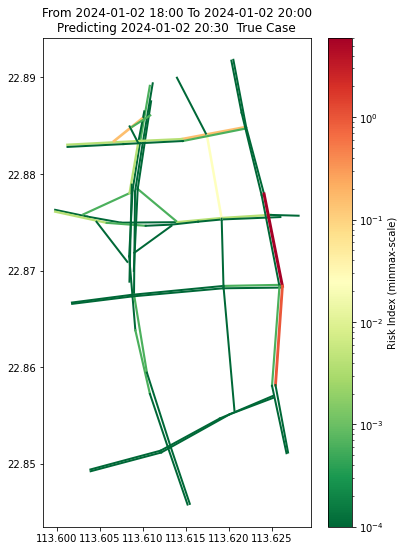

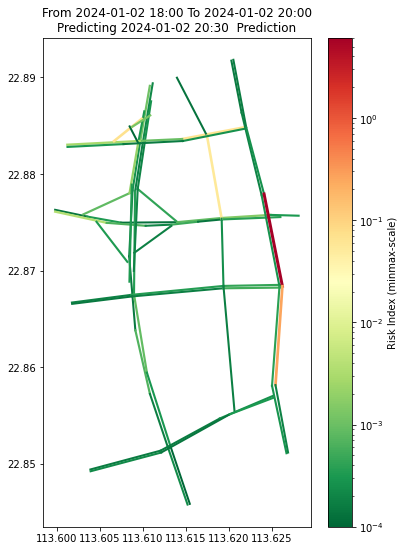

In [47]:
number, i = 19, 0  # 20 105 21 68
generate_pic(y_test, number, i, time_test, 'test')
generate_pic(y_pred, number, i, time_test, 'pred')
#generate_pic(y_pred_avg_test, number, i, time_test, 'pred')

### Hyperparameters Specification

In [ ]:
config = [256, 256, 1024, 4, True, 9]
model, history = model(x_train, y_train, x_val, y_val, config, length=length, n_steps=n_steps)

### Plot Error Curve

{'verbose': 1, 'epochs': 100, 'steps': 26}
31


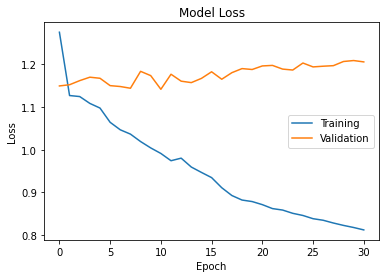

In [10]:
print(history.params)
print(len(history.history['loss']))
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='right')
plt.savefig(f'{path}model_train.png', bbox_inches='tight', dpi=300)
plt.show()

### Baseline Situation

In [9]:
y_pred_avg_train, y_pred_avg_test = [], []
risk_data = pd.read_csv(f'{path}risk.csv', header=0)
dates = risk_data['date'].to_list()
timeindexes = risk_data['time_index'].to_list()
link_ids = risk_data.drop(columns=['date', 'time_index']).columns
n_links, n_outputs = len(link_ids), len(link_ids)
risk_data_group = risk_data.drop(columns=['date']).groupby(by=['time_index']).agg('mean')
y_pred_avg = []

for i in range(int(24 * 60 / interval) + length, duration * int(24 * 60 / interval) - n_steps):
    if judge_holiday(dates[i]) == 0 and timeindexes[i - length] * interval / 60 >= 6 and 0 < timeindexes[i + n_steps - 1] * interval / 60 <= 22 and timeindexes[i] * interval / 60 >= 6:
        start_hour = risk_data['time_index'].iloc[i]
        end_hour = risk_data['time_index'].iloc[i + n_steps - 1]
        #risk_data_group = risk_data.iloc[:i].drop(columns=['date']).groupby(by=['time_index']).agg('mean')
        y_pred_avg.append(risk_data_group.iloc[start_hour:(end_hour + 1), :n_outputs].to_numpy())

train_length = math.floor(len(y_pred_avg) * train_ratio)
y_pred_avg_train, y_pred_avg_test = y_pred_avg[:train_length], y_pred_avg[train_length:]
y_pred_avg_train, y_pred_avg_test = np.array(y_pred_avg_train), np.array(y_pred_avg_test)
val_idx = round(y_pred_avg_train.shape[0] * 0.1)
y_pred_avg_train, y_pred_avg_val = y_pred_avg_train[:-val_idx], y_pred_avg_train[-val_idx:]

# num_train, num_val, num_test = y_pred_avg_train.shape[0], y_pred_avg_val.shape[0], y_pred_avg_test.shape[0]
# y_pred_avg = np.concatenate([y_pred_avg_train, y_pred_avg_val, y_pred_avg_test])
# y_pred_avg_0 = y_pred_avg
# for j in range(len(ref)):
#     y_pred_avg_0[j] = y_pred_avg[ref[j]]
# y_pred_avg_train, y_pred_avg_val, y_pred_avg_test = y_pred_avg_0[:num_train], y_pred_avg_0[num_train:-num_test], y_pred_avg_0[-num_test:]

sw_errors = stepwise_error(y_train, y_pred_avg_train, n_steps)
print('Baseline Performance(Train):')
print(f"MSE: {np.average(sw_errors['MSE'])} - Acc@K: {np.average(sw_errors['ACC'])} \n")
sw_errors = stepwise_error(y_test, y_pred_avg_test, n_steps)
print('Baseline Performance(Test):')
print(f"MSE: {np.average(sw_errors['MSE'])} - Acc@K: {np.average(sw_errors['ACC'])} \n")

Baseline Performance(Train):
MSE: 0.8640171461239863 - Acc@K: 0.620702087011415 

Baseline Performance(Test):
MSE: 0.8519681763285024 - Acc@K: 0.6060362102124768 

